# HR ATTRIBUTION

In [37]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree  
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score
from scipy.stats import pearsonr

# 1.) Import, split data into X/y, plot y data as bar charts, turn X categorical variables binary and tts.

In [72]:
df = pd.read_csv("HR_Analytics.csv")

In [67]:
#Split into Y/X
y = df[["Attrition"]].copy()
X = df.drop("Attrition", axis = 1)

In [68]:
#Change attrition to binary vars
y["Attrition"] = [1 if i == "Yes" else 0 for i in y["Attrition"]]

#Get counts by class for graph
class_counts = y.value_counts()

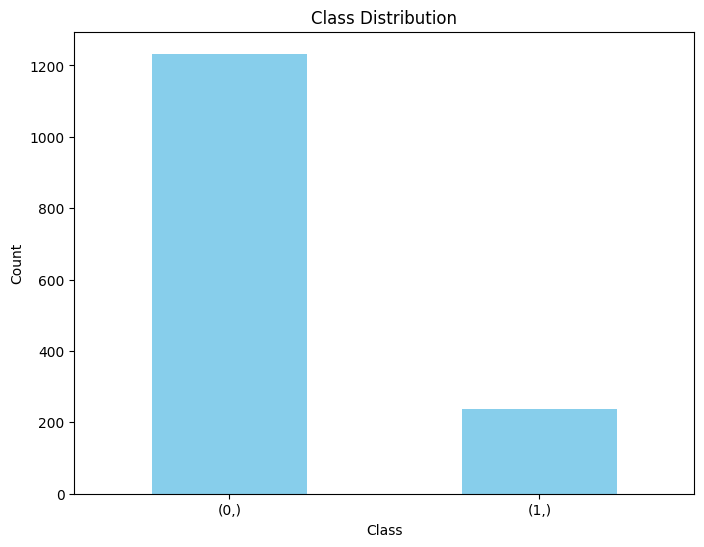

In [69]:
#Plot Graph
plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.xticks(rotation=0)  # Remove rotation of x-axis labels
plt.show()

Can see that most people don't leave this company, but in the last year, 200/1400 people left the company -- we want to minimize that amount.

In [73]:
# Step 1: Identify string columns
string_columns = X.columns[X.dtypes == 'object']

# Step 2: Convert string columns to categorical
for col in string_columns:
    X[col] = pd.Categorical(X[col])

# Step 3: Create dummy columns
X = pd.get_dummies(X, columns = string_columns, prefix = string_columns, drop_first=True)
    #have to include drop_first otherwise you'll get perfect multicollinearity or you'll get cols for both values
# Test/Train Split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

# 2.) Using the default Decision Tree, what is the In vs. OOS accuracy?

In [74]:
clf = DecisionTreeClassifier()
clf.fit(x_train,y_train)
y_pred=clf.predict(x_train)
acc=accuracy_score(y_train,y_pred)
print("In-Sample Accuracy: " , round(acc,2))
    #This is just fitting a normal deicision tree classifier using the defaults for when to stop splitting

y_pred=clf.predict(x_test)
acc=accuracy_score(y_test,y_pred)
print("OOS Accuracy: " , round(acc,2))

In-Sample Accuracy:  1.0
OOS Accuracy:  0.78


if you overfit the model, you get 100% accuracy, and we only care about the OOS, so that's the problem here.

# 3.) Run a grid search CV using F1 score to find the best metrics. What's the In- and Out-of-Sample accuracy now?

In [75]:
# Define the hyperparameter grid to search through
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(1, 11),  # Range of max_depth values to try
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
    #now we're testing out fitting max_depth btwn 1:11, and will do a 5-fold CV for all of these

#Set Classifier
dt_classifier = DecisionTreeClassifier(random_state=42)

#Choose our Scorer as F1 score
scoring = make_scorer(f1_score, average='weighted')

grid_search = GridSearchCV(estimator = dt_classifier, param_grid = param_grid, scoring = scoring, cv = 5)

grid_search.fit(x_train, y_train)

# Get the best parameters and the best score   
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best F1-Score:", best_score)


Best Parameters: {'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 2}
Best F1-Score: 0.8214764475510983


In [76]:
#Best params is a dictionary object, and if we put the *'s it will take the best

clf = tree.DecisionTreeClassifier(**best_params, random_state =42)
clf.fit(x_train,y_train)
y_pred = clf.predict(x_train)
acc = accuracy_score(y_train,y_pred)
print("In-Sample Accuracy: " , round(acc,2))

y_pred = clf.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print("OOS Accuracy: " , round(acc,2))

In-Sample Accuracy:  0.91
OOS Accuracy:  0.83


Result: model complexity went down, so IS accuracy went down and OOS went up

# 4.) Plot ......

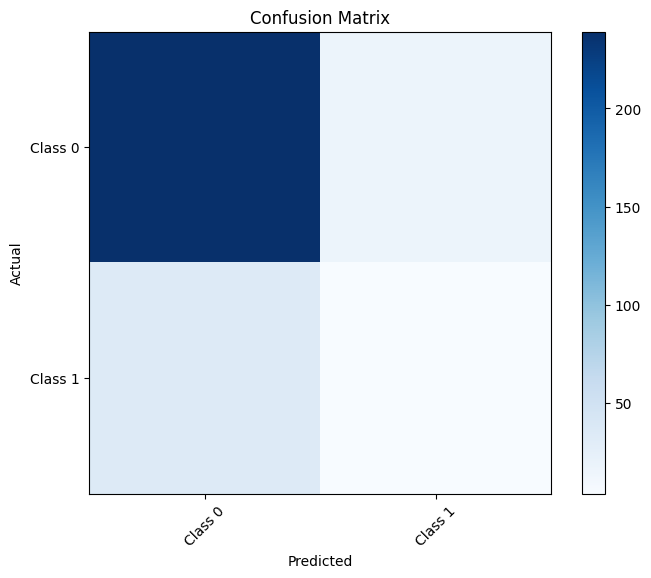

In [33]:
# Make predictions on the test data
y_pred = clf.predict(x_test)
y_prob = clf.predict_proba(x_test)[:, 1]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(conf_matrix))
plt.xticks(tick_marks, ['Class 0', 'Class 1'], rotation=45)
plt.yticks(tick_marks, ['Class 0', 'Class 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [34]:
feature_importance = clf.feature_importances_

# Sort features by importance and select the top 10
top_n = 10
top_feature_indices = np.argsort(feature_importance)[::-1][:top_n]
top_feature_names = X.columns[top_feature_indices]
top_feature_importance = feature_importance[top_feature_indices]

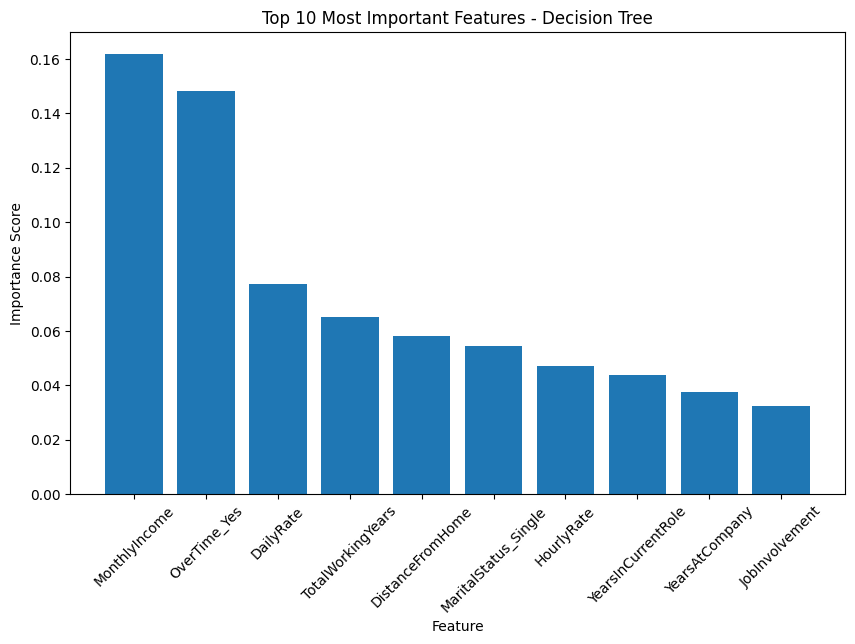

In [35]:
# Plot the top 10 most important features
plt.figure(figsize=(10, 6))
plt.bar(top_feature_names, top_feature_importance)
plt.xlabel('Feature')
plt.ylabel('Importance Score')
plt.title('Top 10 Most Important Features - Decision Tree')
plt.xticks(rotation=45)
plt.show()

In [36]:
# Plot the Decision Tree for better visualization of the selected features
plt.figure(figsize=(12, 6))
plot_tree(clf, filled=True, feature_names=X.columns, class_names=["Yes", "No"], rounded=True, fontsize=7)
plt.title('Decision Tree Classifier')
plt.show()

InvalidParameterError: The 'feature_names' parameter of plot_tree must be an instance of 'list' or None. Got Index(['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EmployeeCount',
       'EmployeeNumber', 'EnvironmentSatisfaction', 'HourlyRate',
       'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome',
       'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike',
       'PerformanceRating', 'RelationshipSatisfaction', 'StandardHours',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager',
       'BusinessTravel_Travel_Frequently', 'BusinessTravel_Travel_Rarely',
       'Department_Research & Development', 'Department_Sales',
       'EducationField_Life Sciences', 'EducationField_Marketing',
       'EducationField_Medical', 'EducationField_Other',
       'EducationField_Technical Degree', 'Gender_Male',
       'JobRole_Human Resources', 'JobRole_Laboratory Technician',
       'JobRole_Manager', 'JobRole_Manufacturing Director',
       'JobRole_Research Director', 'JobRole_Research Scientist',
       'JobRole_Sales Executive', 'JobRole_Sales Representative',
       'MaritalStatus_Married', 'MaritalStatus_Single', 'OverTime_Yes'],
      dtype='object') instead.

<Figure size 1200x600 with 0 Axes>

# 5.) Looking at the graphs. what would be your suggestions to try to improve employee retention? What additional information would you need for a better plan? Plot anything you think would assist in your assessment.

## ANSWER :

We would probably want to start with monthly income and overtime data because these were our two most important features. In order to improve employee retention we would probably want to increase monthly income and reduce overtime.

In [79]:
#Calculate correlation between features
print(np.corrcoef(np.array(X["OverTime_Yes"]), np.array(y["Attrition"])))
    #we can see that working overtime more often makes more people leave

print(np.corrcoef(np.array(X["MonthlyIncome"]), np.array(y["Attrition"])))
    #Similarly, we can see that increased monthly income results in less attrition


[[1.         0.24611799]
 [0.24611799 1.        ]]
[[ 1.         -0.15983958]
 [-0.15983958  1.        ]]


# 6.) Using the Training Data, if they made everyone work overtime. What would have been the expected difference in client retention?

In [55]:
#Calculate experiment data
x_train_experiment = x_train.copy()
x_train_experiment["OverTime_Yes"] = 0

y_pred = clf.predict(x_train)
y_pred_experiment = clf.predict(x_train_experiment)
    #clf is model fit with optimized params

diff = sum(y_pred - y_pred_experiment)
print("Expected Decrease in Attritition: ", diff)

Expected Decrease in Attritition:  59


If no one would have worked overtime, we would have retained an additional 59.

# 7.) If the company loses an employee, there is a cost to train a new employee for a role ~2.8 * their monthly income.
## To make someone not work overtime costs the company 2K per person.
## Is it profitable for the company to remove overtime? If so/not by how much? 
## What do you suggest to maximize company profits?

In [56]:
x_train_experiment["Y"] = y_pred
x_train_experiment["Y_exp"] = y_pred_experiment
x_train_experiment["RetChange"] = x_train_experiment["Y_exp"] - x_train_experiment["Y"]

#
sav = sum(-2.8 * x_train_experiment["RetChange"] * x_train_experiment["MonthlyIncome"])
cost = len(x_train[x_train["OverTime_Yes"] == 1]) * 2000

In [80]:
profit = sav - cost
print("Profits of Proposed Strategy: {:,.10}".format(profit))

Profits of Proposed Strategy: -75,328.4


## ANSWER : 

We have to keep them working overtime since the savings from retaining these employees do not outweigh the costs.

# 8.) Use your model and get the expected change in retention for raising and lowering peoples income. Plot the outcome of the experiment. Comment on the outcome of the experiment and your suggestions to maximize profit.

In [84]:
profits = []

#Run loop over experimental raise values
for raise_amount in range(-1000, 1000, 100):
    
    x_train_experiment = x_train.copy()
    x_train_experiment["MonthlyIncome"] = x_train_experiment["MonthlyIncome"] + raise_amount

    y_pred = clf.predict(x_train)
    y_pred_exper2 = clf.predict(x_train_experiment)

    x_train_experiment["Y"] = y_pred
    x_train_experiment["Y_exp"] = y_pred_exper2
    x_train_experiment["RetChange"] = x_train_experiment["Y_exp"] - x_train_experiment["Y"]


    sav = sum(-2.8 * x_train_experiment["RetChange"] * x_train_experiment["MonthlyIncome"])
    cost = len(x_train) * raise_amount
    profits.append(sav - cost)

print("Profit ", profits)

Profit  [1087584.4, 979524.0, 864992.8, 750738.8, 629778.8, 530138.0, 424200.0, 326096.4, 228440.8, 110714.8, 0.0, -75328.40000000001, -127503.60000000002, -240914.8, -311586.80000000005, -416449.6000000001, -527889.6000000001, -639329.6000000001, -750769.6000000001, -854999.6000000001]


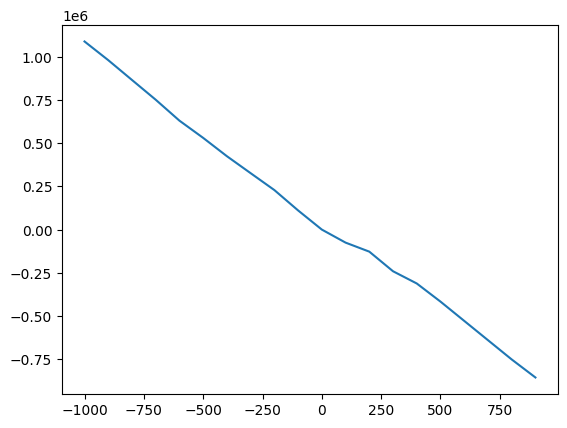

In [85]:
plt.plot(range(-1000, 1000, 100), profits)
plt.show()

## ANSWER : 

The graph shows that with the negative raise amount is where we have the highest profits. Therefore the model is suggesting that we should pay the employees as little as possible - we don't really care if they leave the firm because the savings are still worth it.